<a href="https://colab.research.google.com/github/sowmen/Deepfake-Challenge-Kaggle/blob/master/Contrast_Correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import cv2
import glob
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
import imageio
import sys
import time

In [0]:
font = cv2.FONT_HERSHEY_SIMPLEX 
org = (50, 200) 
fontScale = 3
thickness = 4
color = (0, 0, 255)

In [0]:
from scipy.linalg import fractional_matrix_power

def image_agcwd(img, a=0.25, truncated_cdf=False):
    h,w = img.shape[:2]
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf.max()
    prob_normalized = hist / hist.sum()

    unique_intensity = np.unique(img)
    intensity_max = unique_intensity.max()
    intensity_min = unique_intensity.min()
    prob_min = prob_normalized.min()
    prob_max = prob_normalized.max()
    
    pn_temp = (prob_normalized - prob_min) / (prob_max - prob_min)
    pn_temp[pn_temp>0] = prob_max * (pn_temp[pn_temp>0]**a)
    pn_temp[pn_temp<0] = prob_max * (-((-pn_temp[pn_temp<0])**a))
    prob_normalized_wd = pn_temp / pn_temp.sum() # normalize to [0,1]
    cdf_prob_normalized_wd = prob_normalized_wd.cumsum()
    
    if truncated_cdf: 
        inverse_cdf = np.maximum(0.5,1 - cdf_prob_normalized_wd)
    else:
        inverse_cdf = 1 - cdf_prob_normalized_wd
    
    img_new = img.copy()
    for i in unique_intensity:
        img_new[img==i] = np.round(255 * (i / 255)**inverse_cdf[i])
   
    return img_new

def process_bright(img):
    img_negative = 255 - img
    agcwd = image_agcwd(img_negative, a=0.25, truncated_cdf=False)
    reversed = 255 - agcwd
    return reversed

def process_dimmed(img):
    agcwd = image_agcwd(img, a=0.75, truncated_cdf=True)
    return agcwd

def AGCWD(img):
    st = time.time()
    # Extract intensity component of the image
    YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y = YCrCb[:,:,0]
    # Determine whether image is bright or dimmed
    threshold = 0.3
    exp_in = 112 # Expected global average intensity 
    M,N = img.shape[:2]
    mean_in = np.sum(Y/(M*N)) 
    t = (mean_in - exp_in)/ exp_in
    
    # Process image for gamma correction
    img_output = None
    if t < -threshold: # Dimmed Image
        result = process_dimmed(Y)
        YCrCb[:,:,0] = result
        img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
        img_output = cv2.putText(img_output, 'AGCWD_Dark', org, font,  
                   fontScale, color, thickness, cv2.LINE_AA)
    elif t > threshold: # Bright Image
        result = process_bright(Y)
        YCrCb[:,:,0] = result
        img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2BGR)
        img_output = cv2.putText(img_output, 'AGCWD_Bright', org, font,  
                   fontScale, color, thickness, cv2.LINE_AA)
    else:
        img_output = img
        img_output = cv2.putText(img_output, 'AGCWD_None', org, font,  
                   fontScale, color, thickness, cv2.LINE_AA)

    en = time.time() - st
    print(f"AGCWD: {en}")
    return img_output

In [0]:
def CLAHE(bgr):
    st = time.time()
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    bgr = cv2.putText(bgr, 'CLAHE', org, font,  
                   fontScale, color, thickness, cv2.LINE_AA) 
    en = time.time() - st
    print(f"CLAHE: {en}")
    return bgr

In [0]:
def histogram_equalization(img_in):
    st = time.time()
    # segregate color streams
    b,g,r = cv2.split(img_in)
    h_b, bin_b = np.histogram(b.flatten(), 256, [0, 256])
    h_g, bin_g = np.histogram(g.flatten(), 256, [0, 256])
    h_r, bin_r = np.histogram(r.flatten(), 256, [0, 256])
    # calculate cdf    
    cdf_b = np.cumsum(h_b)  
    cdf_g = np.cumsum(h_g)
    cdf_r = np.cumsum(h_r)
        
    # mask all pixels with value=0 and replace it with mean of the pixel values 
    cdf_m_b = np.ma.masked_equal(cdf_b,0)
    cdf_m_b = (cdf_m_b - cdf_m_b.min())*255/(cdf_m_b.max()-cdf_m_b.min())
    cdf_final_b = np.ma.filled(cdf_m_b,0).astype('uint8')

    cdf_m_g = np.ma.masked_equal(cdf_g,0)
    cdf_m_g = (cdf_m_g - cdf_m_g.min())*255/(cdf_m_g.max()-cdf_m_g.min())
    cdf_final_g = np.ma.filled(cdf_m_g,0).astype('uint8')
    cdf_m_r = np.ma.masked_equal(cdf_r,0)
    cdf_m_r = (cdf_m_r - cdf_m_r.min())*255/(cdf_m_r.max()-cdf_m_r.min())
    cdf_final_r = np.ma.filled(cdf_m_r,0).astype('uint8')
    # merge the images in the three channels
    img_b = cdf_final_b[b]
    img_g = cdf_final_g[g]
    img_r = cdf_final_r[r]

    img_out = cv2.merge((img_b, img_g, img_r))
    # validation
    equ_b = cv2.equalizeHist(b)
    equ_g = cv2.equalizeHist(g)
    equ_r = cv2.equalizeHist(r)
    equ = cv2.merge((equ_b, equ_g, equ_r))
    #print(equ)
    #cv2.imwrite('output_name.png', equ)

    img_out = cv2.putText(img_out, 'HEQ', org, font,  
                   fontScale, color, thickness, cv2.LINE_AA) 
    
    en = time.time() - st
    print(f"HEQ: {en}")
    return img_out

In [0]:
import scipy, scipy.misc, scipy.signal
from PIL import Image

def computeTextureWeights(fin, sigma, sharpness):
    dt0_v = np.vstack((np.diff(fin, n=1, axis=0), fin[0,:]-fin[-1,:]))
    dt0_h = np.vstack((np.diff(fin, n=1, axis=1).conj().T, fin[:,0].conj().T-fin[:,-1].conj().T)).conj().T

    gauker_h = scipy.signal.convolve2d(dt0_h, np.ones((1,sigma)), mode='same')
    gauker_v = scipy.signal.convolve2d(dt0_v, np.ones((sigma,1)), mode='same')

    W_h = 1/(np.abs(gauker_h)*np.abs(dt0_h)+sharpness)
    W_v = 1/(np.abs(gauker_v)*np.abs(dt0_v)+sharpness)

    return  W_h, W_v

def solveLinearEquation(IN, wx, wy, lamda):
    [r, c] = IN.shape
    k = r * c
    dx =  -lamda * wx.flatten('F')
    dy =  -lamda * wy.flatten('F')
    tempx = np.roll(wx, 1, axis=1)
    tempy = np.roll(wy, 1, axis=0)
    dxa = -lamda *tempx.flatten('F')
    dya = -lamda *tempy.flatten('F')
    tmp = wx[:,-1]
    tempx = np.concatenate((tmp[:,None], np.zeros((r,c-1))), axis=1)
    tmp = wy[-1,:]
    tempy = np.concatenate((tmp[None,:], np.zeros((r-1,c))), axis=0)
    dxd1 = -lamda * tempx.flatten('F')
    dyd1 = -lamda * tempy.flatten('F')
    
    wx[:,-1] = 0
    wy[-1,:] = 0
    dxd2 = -lamda * wx.flatten('F')
    dyd2 = -lamda * wy.flatten('F')
    
    Ax = scipy.sparse.spdiags(np.concatenate((dxd1[:,None], dxd2[:,None]), axis=1).T, np.array([-k+r,-r]), k, k)
    Ay = scipy.sparse.spdiags(np.concatenate((dyd1[None,:], dyd2[None,:]), axis=0), np.array([-r+1,-1]), k, k)
    D = 1 - ( dx + dy + dxa + dya)
    A = ((Ax+Ay) + (Ax+Ay).conj().T + scipy.sparse.spdiags(D, 0, k, k)).T
    
    tin = IN[:,:]
    tout = scipy.sparse.linalg.spsolve(A, tin.flatten('F'))
    OUT = np.reshape(tout, (r, c), order='F')
    
    return OUT

def tsmooth(img, lamda=0.01, sigma=3.0, sharpness=0.001):
    I = cv2.normalize(img.astype('float64'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    x = np.copy(I)
    wx, wy = computeTextureWeights(x, sigma, sharpness)
    S = solveLinearEquation(I, wx, wy, lamda)
    return S

def rgb2gm(I):
    if (I.shape[2] == 3):
        I = cv2.normalize(I.astype('float64'), None, 0.0, 1.0, cv2.NORM_MINMAX)
        I = np.abs((I[:,:,0]*I[:,:,1]*I[:,:,2]))**(1/3)

    return I

def applyK(I, k, a=-0.3293, b=1.1258):
    f = lambda x: np.exp((1-x**a)*b)
    beta = f(k)
    gamma = k**a
    J = (I**gamma)*beta
    return J

def entropy(X):
    tmp = X * 255
    tmp[tmp > 255] = 255
    tmp[tmp<0] = 0
    tmp = tmp.astype(np.uint8)
    _, counts = np.unique(tmp, return_counts=True)
    pk = np.asarray(counts)
    pk = 1.0*pk / np.sum(pk, axis=0)
    S = -np.sum(pk * np.log2(pk), axis=0)
    return S

def maxEntropyEnhance(I, isBad, a=-0.3293, b=1.1258):
    # Esatimate k
    tmp = cv2.resize(I, (50,50), interpolation=cv2.INTER_AREA)
    tmp[tmp<0] = 0
    tmp = tmp.real
    Y = rgb2gm(tmp)
    
    isBad = isBad * 1
    isBad = np.array(Image.fromarray((isBad * 255).astype(np.uint8)).resize((50,50), Image.BICUBIC)) #scipy.misc.imresize(isBad, (50,50), interp='bicubic', mode='F')
    isBad[isBad<0.5] = 0
    isBad[isBad>=0.5] = 1
    Y = Y[isBad==1]
    
    if Y.size == 0:
       J = I
       return J
    
    f = lambda k: -entropy(applyK(Y, k))
    opt_k = scipy.optimize.fminbound(f, 1, 7)
    
    # Apply k
    J = applyK(I, opt_k, a, b) - 0.01
    return J
    
def Ying_2017_CAIP(img, mu=0.5, a=-0.3293, b=1.1258):
    st = time.time()
    
    lamda = 0.5
    sigma = 5
    I = cv2.normalize(img.astype('float64'), None, 0.0, 1.0, cv2.NORM_MINMAX)

    # Weight matrix estimation
    t_b = np.max(I, axis=2)
    t_our = cv2.resize(tsmooth(np.array(Image.fromarray(t_b).resize((t_b.shape[1]//2,t_b.shape[0]//2), Image.BICUBIC)) , lamda, sigma), (t_b.shape[1], t_b.shape[0]), interpolation=cv2.INTER_AREA)
    # Apply camera model with k(exposure ratio)
    isBad = t_our < 0.5
    J = maxEntropyEnhance(I, isBad)

    # W: Weight Matrix
    t = np.zeros((t_our.shape[0], t_our.shape[1], I.shape[2]))
    for i in range(I.shape[2]):
        t[:,:,i] = t_our
    W = t**mu

    I2 = I*W
    J2 = J*(1-W)

    result = I2 + J2
    result = result * 255
    result[result > 255] = 255
    result[result<0] = 0
    result = result.astype(np.uint8)

    result = cv2.putText(result, 'YING', org, font,  
                   fontScale, color, thickness, cv2.LINE_AA) 
    
    en = time.time() - st
    print(f"Ying: {en}")
    return result

In [0]:
def main(input_dir):    
    img_paths = glob.glob(input_dir+'/*')
    for path in img_paths:
        inp = cv2.imread(path, 1)
        name = path.split('/')[-1].split('.')[0]
        
        print(name + "--- >")

        
        heq = histogram_equalization(inp.copy())
        
        clahe = CLAHE(inp.copy())
        agcwd = AGCWD(inp.copy())
        ying = Ying_2017_CAIP(cv2.cvtColor(inp, cv2.COLOR_BGR2RGB))

        imgor = cv2.cvtColor(inp, cv2.COLOR_BGR2RGB)
        agcwd = cv2.cvtColor(agcwd, cv2.COLOR_BGR2RGB)
        heq = cv2.cvtColor(heq, cv2.COLOR_BGR2RGB)
        clahe = cv2.cvtColor(clahe, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(20, 18))

        plt.subplot(131)
        plt.imshow(imgor)

        plt.subplot(132)
        plt.imshow(agcwd)

        plt.subplot(133)
        plt.imshow(heq)
        plt.show()

        plt.figure(figsize=(15, 12))
        plt.subplot(121)
        plt.imshow(clahe)

        plt.subplot(122)
        plt.imshow(ying)


        plt.show()

In [0]:
i1 = cv2.imread("/content/drive/My Drive/asdpeebotb.mp4_FAKE/00002.jpg")
o2 = ying(cv2.cvtColor(i1, cv2.COLOR_BGR2RGB))
plt.figure(figsize=(25, 22))
plt.subplot(121)
plt.imshow(cv2.cvtColor(i1, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.imshow(o2)

plt.show()

00001--- >
HEQ: 0.18809914588928223
CLAHE: 0.19100022315979004
AGCWD: 0.5234363079071045
Ying: 30.14049768447876


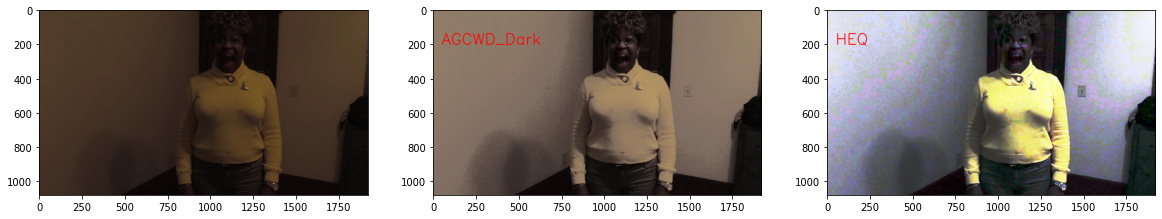

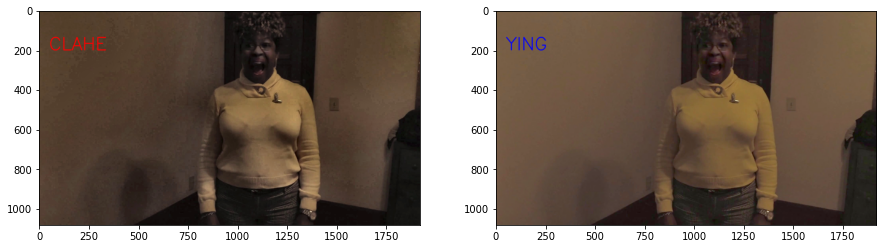

In [10]:
main("/content/drive/My Drive/asdpeebotb.mp4_FAKE")

00001--- >
HEQ: 0.1284620761871338
CLAHE: 0.04534792900085449
AGCWD: 0.009311437606811523
Ying: 29.520142316818237


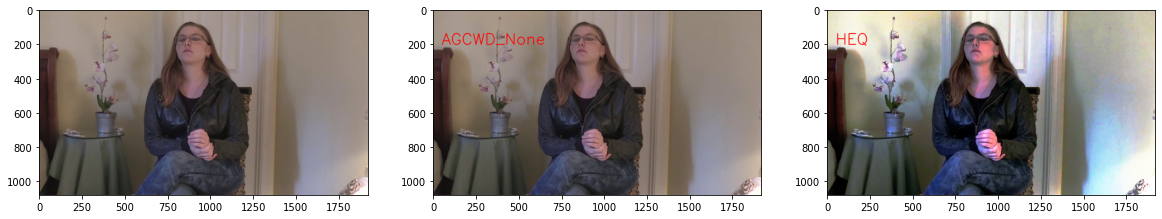

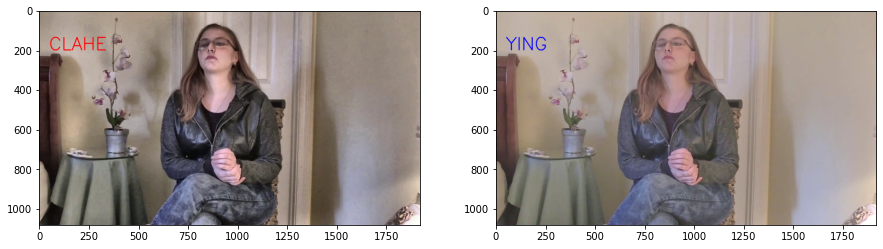

In [11]:
main("/content/drive/My Drive/eivxffliio.mp4_FAKE")

00001--- >
HEQ: 0.12937283515930176
CLAHE: 0.04970860481262207
AGCWD: 0.3088834285736084
Ying: 29.344085931777954


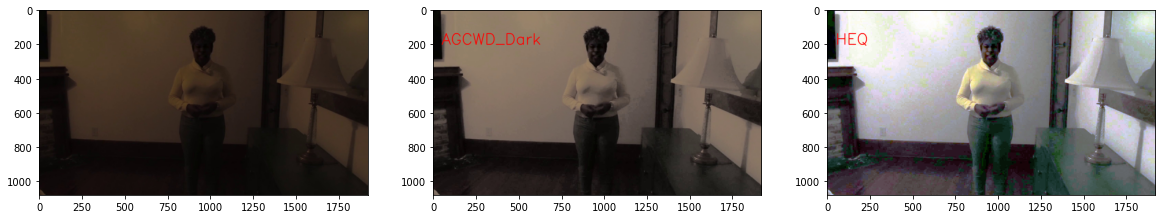

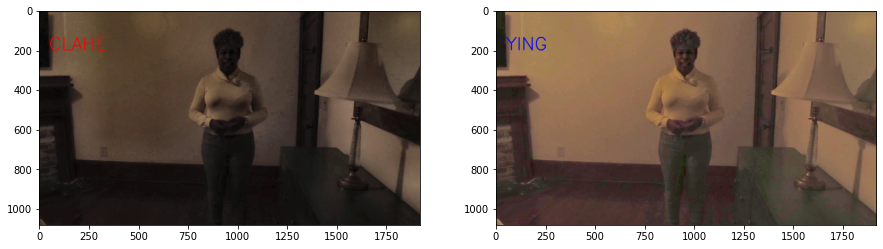

In [12]:
main("/content/drive/My Drive/abofeumbvv.mp4_FAKE")

00092--- >
HEQ: 0.13838911056518555
CLAHE: 0.0457613468170166
AGCWD: 0.02015972137451172
Ying: 29.639954328536987


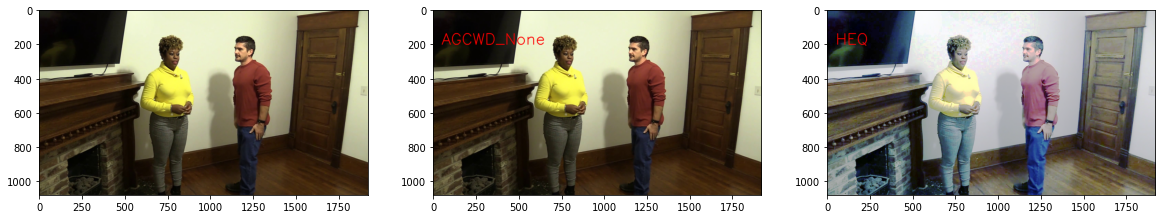

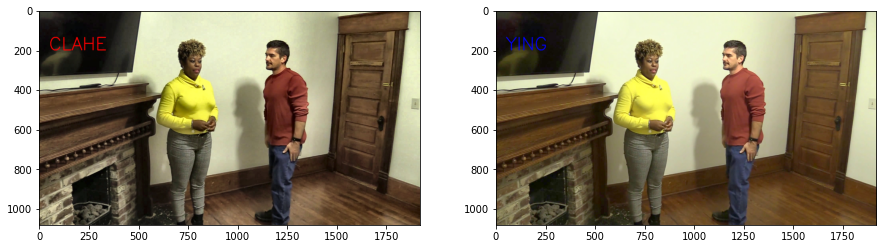

00020--- >
HEQ: 0.1386890411376953
CLAHE: 0.04578113555908203
AGCWD: 0.009326934814453125
Ying: 29.693004846572876


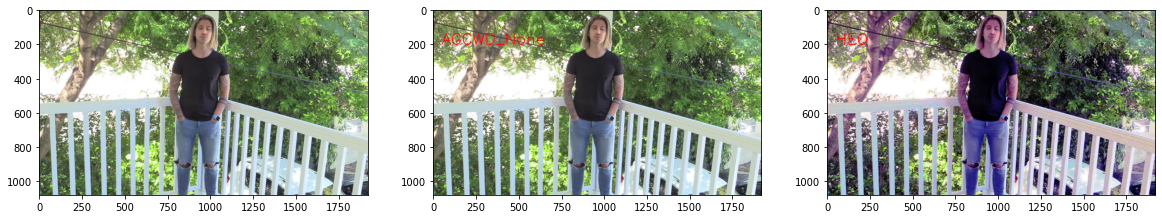

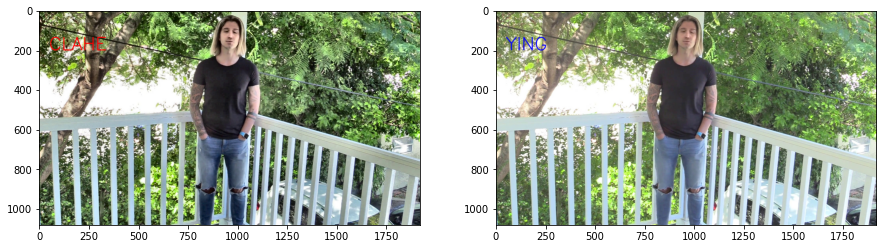

00109--- >
HEQ: 0.12108659744262695
CLAHE: 0.04585766792297363
AGCWD: 0.2792701721191406
Ying: 29.538946628570557


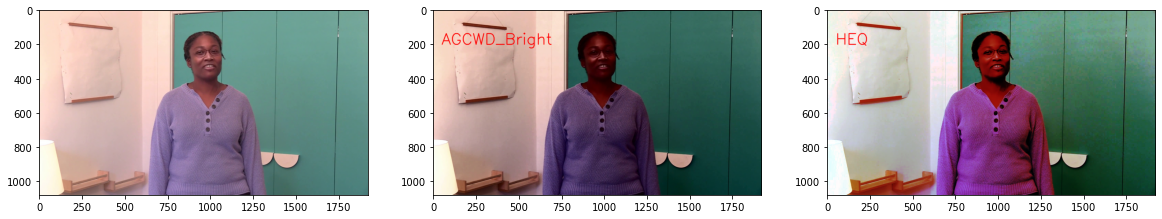

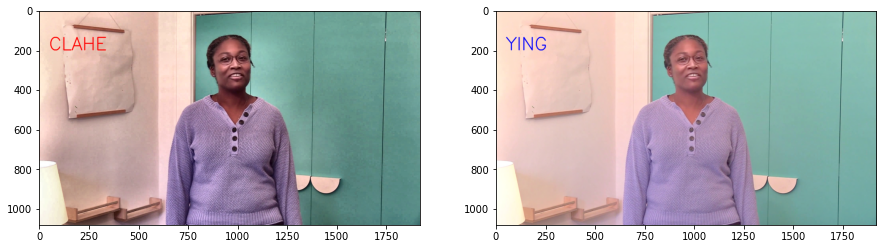

00093--- >
HEQ: 0.13429665565490723
CLAHE: 0.046131134033203125
AGCWD: 0.0190126895904541
Ying: 29.432332515716553


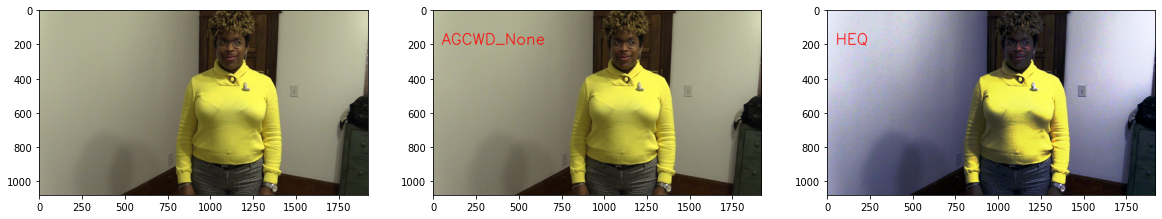

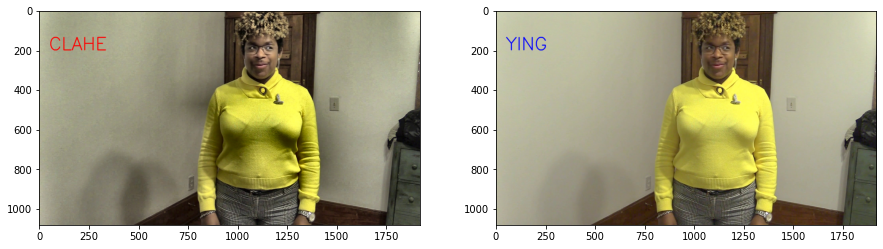

00002--- >
HEQ: 0.12021398544311523
CLAHE: 0.046472787857055664
AGCWD: 0.01669454574584961
Ying: 29.650861263275146


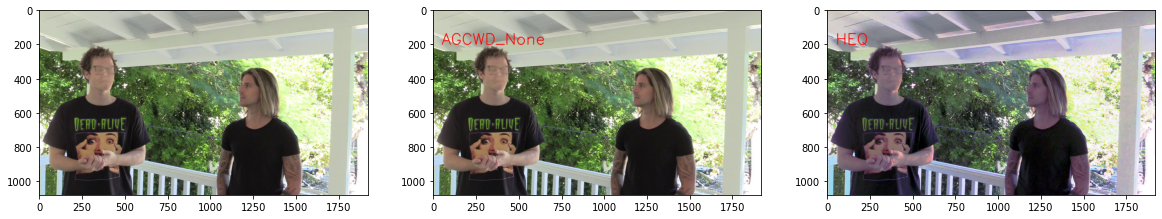

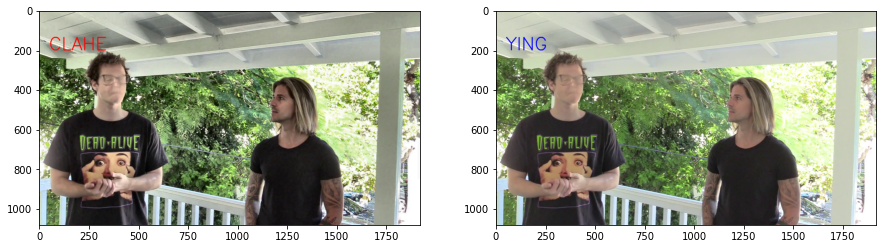

In [14]:
main("ci")